In [31]:
!pip install pygdal

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [8 lines of output]
  running egg_info
  creating C:\Users\Amiya\AppData\Local\Temp\pip-pip-egg-info-5pehpeqz\pygdal.egg-info
  writing C:\Users\Amiya\AppData\Local\Temp\pip-pip-egg-info-5pehpeqz\pygdal.egg-info\PKG-INFO
  writing dependency_links to C:\Users\Amiya\AppData\Local\Temp\pip-pip-egg-info-5pehpeqz\pygdal.egg-info\dependency_links.txt
  writing requirements to C:\Users\Amiya\AppData\Local\Temp\pip-pip-egg-info-5pehpeqz\pygdal.egg-info\requires.txt
  writing top-level names to C:\Users\Amiya\AppData\Local\Temp\pip-pip-egg-info-5pehpeqz\pygdal.egg-info\top_level.txt
  writing manifest file 'C:\Users\Amiya\AppData\Local\Temp\pip-pip-egg-info-5pehpeqz\pygdal.egg-info\SOURCES.txt'
  error: [WinError 2] 系统找不到指定的文件。
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered e

In [3]:
import importlib
import os
import re
import subprocess
import sys
import logging

logging.basicConfig(level=logging.DEBUG, format=' %(asctime)s - %(levelname)s -%(message)s')

# Just need matplotlib and numpy :)
subprocess.check_output([sys.executable, "-m", "pip", "install", 'numpy', 'matplotlib'])
subprocess.check_output([sys.executable, "-m", "pip", "install", 'proplot', '--no-dependencies'])

proplot_path = importlib.machinery.PathFinder().find_spec('proplot').submodule_search_locations[0]

def alter(file, old_str, new_str):
    with open(file, "r", encoding="utf-8") as f1, open(f"{file}.bak", "w", encoding="utf-8") as f2:
        txt = f1.read()
        changed_txt = re.sub(old_str, new_str, txt, re.S | re.M)
        f2.write(changed_txt)

    os.remove(file)
    os.rename(f"{file}.bak", file)

ori_path_1 = os.path.join(proplot_path, 'colors.py')
ori_str_1 = \
"""    attr = '_cmap_registry' if hasattr\(mcm, '_cmap_registry'\) else 'cmap_d'"""
new_str_1 = \
"""    # attr = '_cmap_registry' if hasattr(mcm, '_cmap_registry') else 'cmap_d'
    attr = '_colormaps' if hasattr(mcm, '_colormaps') else 'cmap_d'"""

ori_path_2 = os.path.join(proplot_path, 'figure.py')
ori_str_2 = \
"""        if self\._cachedRenderer:
            renderer = self\._cachedRenderer"""
new_str_2 = \
"""        # if self._cachedRenderer:
        # renderer = self._cachedRenderer
        # if self.canvas._get_renderer():
        # renderer = self.canvas._get_renderer()
        # else:
        canvas = self.canvas
        if canvas and hasattr(canvas, 'get_renderer'):
            renderer = canvas.get_renderer()"""

ori_path_3 = os.path.join(proplot_path, 'figure.py')
ori_str_3 = \
"""            canvas = self\.canvas
            if canvas and hasattr\(canvas, 'get_renderer'\):
                renderer = canvas\.get_renderer\(\)
            else:
                from matplotlib\.backends.backend_agg import FigureCanvasAgg
                canvas = FigureCanvasAgg\(self\)
                renderer = canvas\.get_renderer\(\)"""
new_str_3 = \
"""            # from matplotlib.backends.backend_agg import FigureCanvasAgg
            # canvas = FigureCanvasAgg(self)
            # renderer = canvas.get_renderer()
            from matplotlib import backend_bases
            renderer = backend_bases._get_renderer(self)"""

ori_path_4 = os.path.join(proplot_path, 'internals/rcsetup.py')
ori_str_4 = "CMAPSEQ = 'Fire'"
new_str_4 = "CMAPSEQ = 'magma'"
ori_path_5 = os.path.join(proplot_path, '__init__.py')
ori_str_5 = "import pkg_resources as pkg"
new_str_5 = "import importlib_metadata"

ori_path_6 = os.path.join(proplot_path, '__init__.py')
ori_str_6 = \
"""try:
    version = __version__ = pkg\.get_distribution\(__name__\)\.version
except pkg\.DistributionNotFound:
    version = __version__ = 'unknown'"""
new_str_6 = "version = __version__ = importlib_metadata.metadata('proplot').get('version')"

alter(ori_path_1, ori_str_1, new_str_1)
alter(ori_path_2, ori_str_2, new_str_2)
alter(ori_path_3, ori_str_3, new_str_3)
alter(ori_path_4, ori_str_4, new_str_4)
alter(ori_path_5, ori_str_5, new_str_5)
alter(ori_path_6, ori_str_6, new_str_6)

try:
    proplot = importlib.import_module('proplot')
    print(f"proplot安装成功 version: {proplot.__version__}")
except Exception as e:
    print(f"proplot安装失败: {e}")

Rebuilding font cache. This usually happens after installing or updating proplot.


proplot安装成功 version: 0.9.7


In [1]:
import seaborn as sns
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import shap
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import proplot as pplt
from scipy.stats import gaussian_kde

In [6]:
# 读取数据集
data = pd.read_csv('I:/PF_NF_climate_sensitivity/all_datasets_reproduce/XGBT_model_analysis/lambda_XGBT/all_diff_XGBT - location.csv').drop('ID', axis=1)
# 分离特征和目标变量
X = data.drop('Delta_lambda_AC1_LAI', axis=1)
y = data['Delta_lambda_AC1_LAI']

# # 计算切分索引
# split_index = int(0.8 * len(data))  # 80%作为训练集，20%作为验证集

# # 划分训练集和验证集
# X_train = X[:split_index]
# y_train = y[:split_index]
# X_test = X[split_index:]
# y_test = y[split_index:]

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=64)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

data

,Location_P/PET,Location_Temp,Location_RD,Location_AGB,Location_BGB,Location_CEC,Location_Clay,Location_Sand,Delta_lambda_AC1_LAI
0,2.447161,10.195129,1.044358,72.822617,20.726291,320.721541,245.981200,475.590500,0.122915
1,2.567283,10.330978,1.488656,77.902913,21.979382,279.526738,295.696653,432.555195,0.143893
2,2.185720,10.923383,1.481443,73.057664,20.794209,277.578929,278.697253,455.342980,0.251082
3,2.352409,9.719322,0.966330,60.616434,22.097854,272.018201,253.423622,458.965076,0.153232
4,2.121277,10.737395,1.397718,65.877385,21.359119,267.525244,258.991240,457.231458,0.388517
...,...,...,...,...,...,...,...,...,...
8240,13.120416,3.191579,0.504409,34.283056,14.642135,514.049582,113.264459,610.368747,0.032747
8241,10.315222,3.395275,0.371666,36.074314,14.822409,477.339399,134.502877,592.778417,0.036919
8242,12.364425,3.196295,0.419987,36.119424,14.764605,491.022079,117.757684,610.422782,-0.056933
8243,11.282410,3.100711,0.532591,33.429501,14.744161,490.637012,120.452889,618.221011,-0.234482


In [3]:
param_grid = {
    'max_depth': [4, 6, 8, 10, 12],
    'n_estimators': [100, 300, 600, 900],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Initialize XGBoost regressor
model = xgb.XGBRegressor()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_result = grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and corresponding RMSE
print("Best Parameters: ", grid_result.best_params_)
print("Best RMSE: ", np.sqrt(-grid_result.best_score_))


Best Parameters:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 600}
Best RMSE:  0.1357807767318641


In [38]:
# 初始化XGBoost回归模型 Best Parameters:  {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 900}
# Best RMSE:  0.13246167497246258 with 5 cv
params = {
   'objective': 'reg:squarederror',
    'max_depth': 10,
    'n_estimators': 600,
    'learning_rate':0.1
}

# 初始化XGBoost回归模型
model = xgb.XGBRegressor(gpu_id=0)

# 训练模型
model.fit(X_train_scaled, y_train)

# 在测试集上进行预测
y_pred = model.predict(X_test_scaled)
# 计算均方根误差（RMSE）
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))

# 计算NSE（Nash-Sutcliffe Efficiency）
nse = 1 - (np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2))
print("NSE (Nash-Sutcliffe Efficiency): {:.2f}".format(nse))

# 计算KGE（Kling-Gupta Efficiency）
mean_obs = np.mean(y_test)
kge = 1 - np.sqrt((np.corrcoef(y_test, y_pred)[0, 1] - 1)**2 +
                 (np.std(y_pred) / np.std(y_test) - 1)**2 +
                 (np.mean(y_pred) / mean_obs - 1)**2)
print("KGE (Kling-Gupta Efficiency): {:.2f}".format(kge))

# 计算R2（决定系数）
r2 = r2_score(y_test, y_pred)
print("R2 (Coefficient of Determination): {:.2f}".format(r2))



#for the train
y_pred_best = model.predict(X_train_scaled)
y_pred = y_pred_best
# 计算均方根误差（RMSE）
rmse = mean_squared_error(y_train, y_pred, squared=False)
print("Root Mean Squared Error (RMSE): {:.2f}".format(rmse))

# 计算NSE（Nash-Sutcliffe Efficiency）
nse = 1 - (np.sum((y_train - y_pred)**2) / np.sum((y_test - np.mean(y_test))**2))
print("NSE (Nash-Sutcliffe Efficiency): {:.2f}".format(nse))

# 计算KGE（Kling-Gupta Efficiency）
mean_obs = np.mean(y_train)
kge = 1 - np.sqrt((np.corrcoef(y_train, y_pred)[0, 1] - 1)**2 +
                 (np.std(y_pred) / np.std(y_train) - 1)**2 +
                 (np.mean(y_pred) / mean_obs - 1)**2)
print("KGE (Kling-Gupta Efficiency): {:.2f}".format(kge))

# 计算R2（决定系数）
r2 = r2_score(y_train, y_pred)
print("R2 (Coefficient of Determination): {:.2f}".format(r2))

Root Mean Squared Error (RMSE): 0.13
NSE (Nash-Sutcliffe Efficiency): 0.64
KGE (Kling-Gupta Efficiency): 0.58
R2 (Coefficient of Determination): 0.64
Root Mean Squared Error (RMSE): 0.06
NSE (Nash-Sutcliffe Efficiency): 0.83
KGE (Kling-Gupta Efficiency): 0.89
R2 (Coefficient of Determination): 0.93


In [39]:

# 为波段重命名
band_names = ['Location_AGB','Location_BGB','Location_P/PET','Location_Temp','Location_CEC','Location_Sand','Location_Clay','Location_RD']  # 用你希望的波段名称替换
# 读取数据集
data = pd.read_csv('I:/PF_NF_climate_sensitivity/all_datasets_reproduce/XGBT_model_analysis/prediceted_by_location/global_XGBT_predicted.csv')
# 分离特征和目标变量
X_world = data[band_names]
X_world



,Location_AGB,Location_BGB,Location_P/PET,Location_Temp,Location_CEC,Location_Sand,Location_Clay,Location_RD
0,0.036128,0.245520,10.582577,-21.205278,364,307,236,5.680000e-14
1,0.110250,0.728502,1.607032,-18.823333,354,316,240,5.680000e-14
2,0.333735,2.112978,0.891786,-18.360833,370,311,249,5.680000e-14
3,0.314835,1.984879,0.863563,-18.132778,362,312,252,5.680000e-14
4,0.083159,0.558945,2.953553,-19.537222,362,320,238,5.680000e-14
...,...,...,...,...,...,...,...,...
15223,0.030799,0.083558,147.718482,-0.648611,369,497,124,1.669032e-03
15224,39.715519,16.216028,3.334678,5.303611,345,555,179,1.068493e-02
15225,45.002201,15.920850,4.415160,4.891667,330,558,175,2.336559e-01
15226,76.486176,22.885479,3.479832,5.102500,349,559,180,1.442705e+00


In [ ]:
y_pred_X_world = model.predict(X_world)

# 将预测的值加入到data中
data['Predicted_Values'] = y_pred_X_world

# 将数据保存为CSV文件
output_path = 'I:/PF_NF_climate_sensitivity/all_datasets_reproduce/XGBT_model_analysis/predicted_data_with_world.csv'
data.to_csv(output_path, index=False)


In [5]:
lambda_train_predict = model.predict(X_train_scaled)
lambda_train_true = y_train
lambda_train = pd.DataFrame({'predict':lambda_train_predict, 'true':lambda_train_true})

lambda_test_predict = model.predict(X_test_scaled)
lambda_test_true = y_test
lambda_test = pd.DataFrame({'predict':lambda_test_predict, 'true':lambda_test_true})

lambda_train.describe()
lambda_test.describe()

,predict,true
count,2474.000000,2474.000000
mean,-0.005008,-0.007621
std,0.193081,0.222791
min,-0.817260,-1.443007
25%,-0.114927,-0.145623
50%,-0.000055,0.013731
75%,0.135301,0.144020
max,0.831343,0.759571


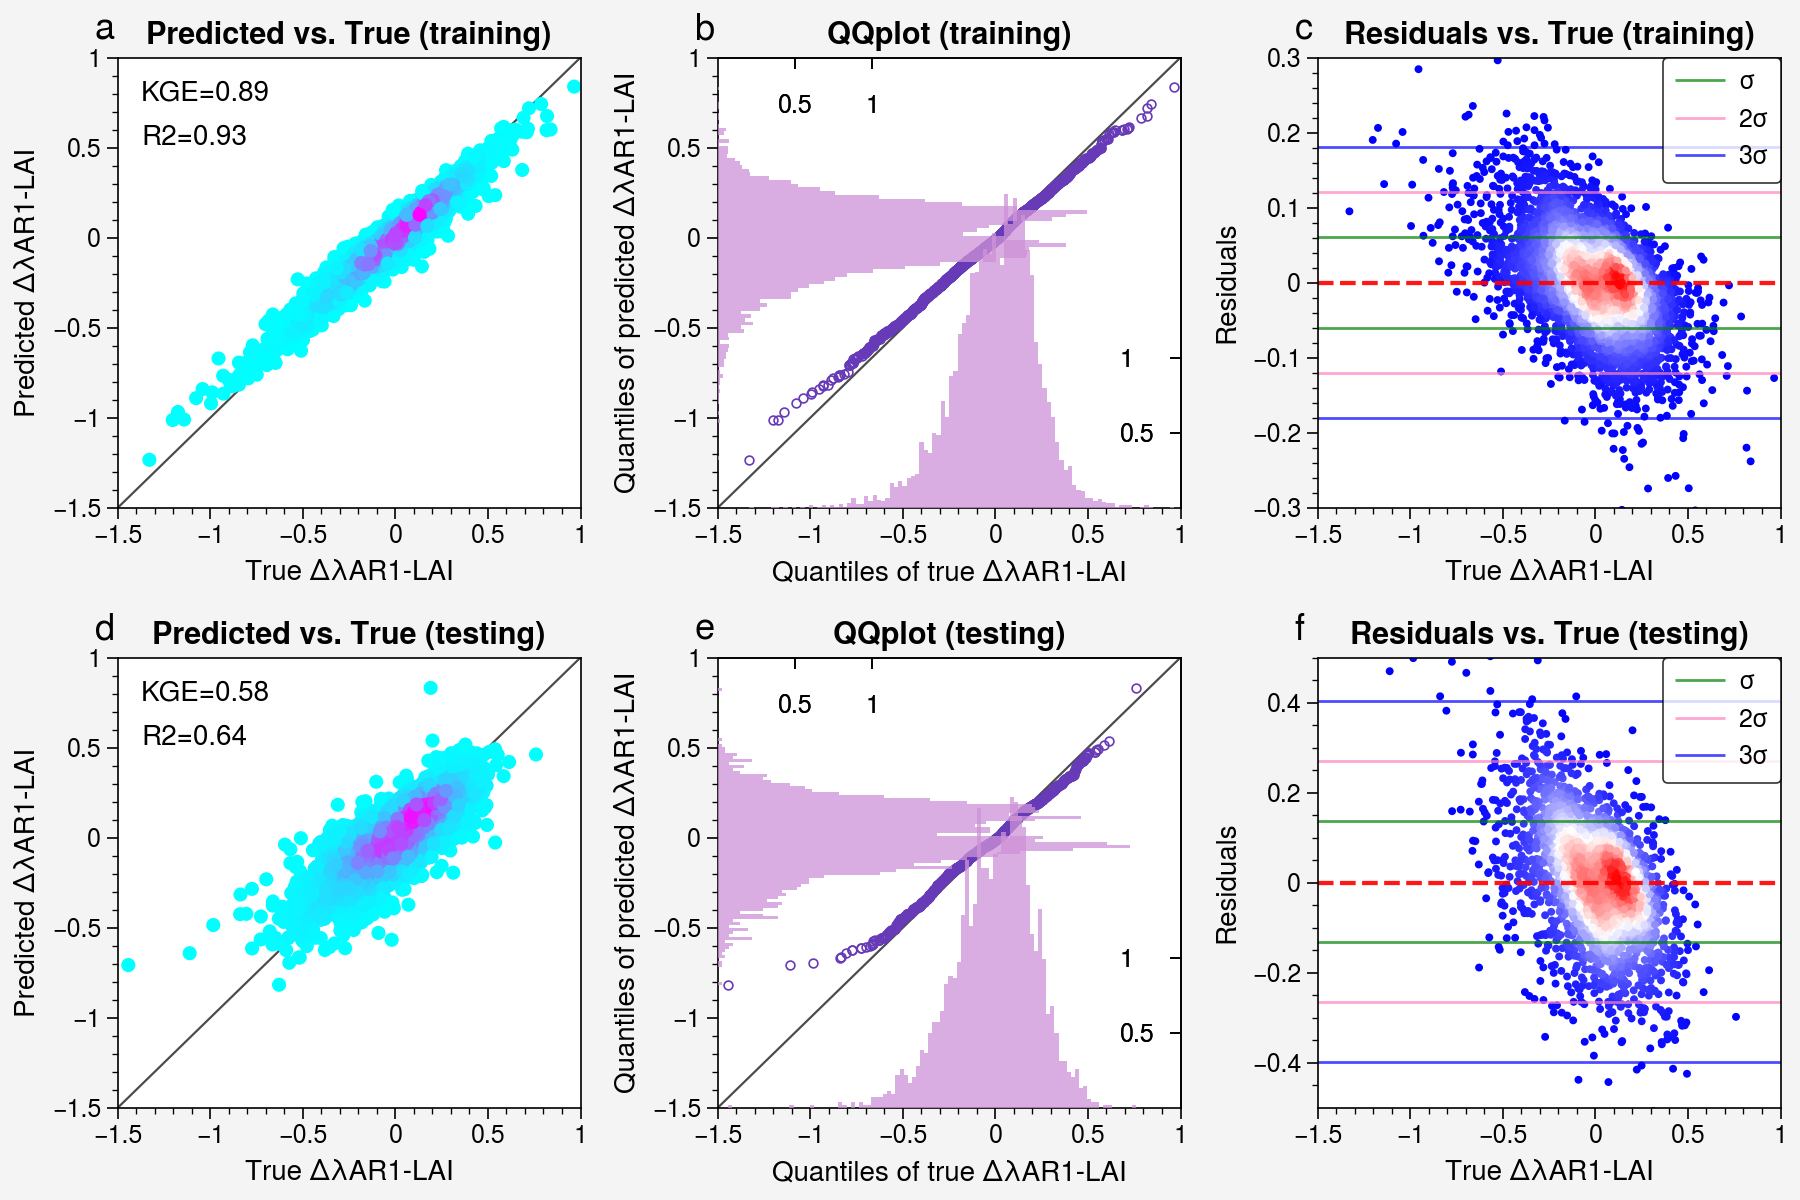

In [12]:
#Reference codes:https://github.com/huangzq681/Explainable_Acid_Rain_Predict/blob/main/Notebooks/xgboost_learning.ipynb(ZQ huang)
def kge(predictions, targets):
    mean_obs = np.mean(predictions)
    kge = 1 - np.sqrt((np.corrcoef(predictions, targets)[0, 1] - 1)**2 +
                 (np.std(targets) / np.std(predictions) - 1)**2 +
                 (np.mean(targets) / mean_obs - 1)**2)
    return kge

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
def add_panel_label(ax, label, x = 0.05, y = 1, fontsize=10):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=fontsize,  va='top', ha='left') #fontweight='bold',

import statsmodels.api as sm
fig, axs = pplt.subplots(ncols=3, nrows=2, figsize=(9,6),share=0)

# ax1 of scatter plot for train set
x = lambda_train['true']
y = lambda_train['predict']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
kge_train = kge(x,y)
corr_train = np.corrcoef(x,y)[0,1]

axs[0].axline((0, 0), slope=1,linewidth=0.8,color='black',alpha=0.7,zorder=0)
axs[0].scatter(x, y, c=z, s=20, cmap='cool')
axs[0].grid(False)
axs[0].set_ylabel('Predicted ΔλAR1-LAI',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[0].set_xlabel('True ΔλAR1-LAI',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[0].set_xlim([-1.5,1])
axs[0].set_ylim([-1.5,1])
axs[0].set_title('Predicted vs. True (training)',fontdict={'fontsize':11,'fontweight': 'bold'})
add_panel_label(axs[0],'KGE='+str(round(kge_train,2)), x=0.05, y=0.95)
add_panel_label(axs[0],'R2='+str(round(corr_train*corr_train,2)), x=0.05, y=0.85)
add_panel_label(axs[0],'a', x=-0.05, y=1.1, fontsize=13)

# ax2 qqplot for train set
x_q = np.sort(x)
y_q = np.sort(y)
axs[1].axline((0, 0), slope=1,linewidth=0.8,color='black',alpha=0.7,zorder=0)
axs[1].scatter(x_q, y_q, s=10, facecolor='none', edgecolor='#673AB7')
axs[1].grid(False)
axs[1].set_ylabel('Quantiles of predicted ΔλAR1-LAI',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[1].set_xlabel('Quantiles of true ΔλAR1-LAI',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[1].set_xlim([-1.5,1])
axs[1].set_ylim([-1.5,1])
axs[1].set_title('QQplot (training)',fontdict={'fontsize':11,'fontweight': 'bold'})
axs1_twinx = axs[1].twinx()
axs1_twinx.hist(x_q, 100, density=True, alpha=0.5, color = '#CE93D8')
axs1_twinx.set_ylim([0,3])
axs1_twinx.tick_params(axis="y",direction="in", pad=-22)
axs1_twinx.yaxis.set_tick_params(which='minor',right=False)
axs1_twinx.set_yticks(axs1_twinx.get_yticks()[1:3])
axs1_twinx.set_yticklabels([0.5,1])
axs1_twiny = axs[1].twiny()
axs1_twiny.hist(y_q, 100, density=True, orientation="horizontal", alpha=0.5, color = '#CE93D8')
axs1_twiny.set_xlim([0,3])
axs1_twiny.tick_params(axis="x",direction="in", pad=-22)
axs1_twiny.xaxis.set_tick_params(which='minor',top=False)
axs1_twiny.set_xticks([0.5,1])
axs1_twiny.set_xticklabels([0.5,1])
add_panel_label(axs[1],'b', x=-0.05, y=1.1, fontsize=13)

# ax3 residual plot for train set
res_train = y - x
res_train_std = np.std(res_train)
res_train_mean = np.mean(res_train)
xy_res_train = np.vstack([x,res_train])
z_res_train = gaussian_kde(xy_res_train)(xy_res_train)
axs[2].axhline(y=0, color='red', alpha=0.7, linewidth=1.5, linestyle='--')
p1 = axs[2].axhline(y=res_train_mean+res_train_std, color='green', alpha=0.7, linewidth=1, linestyle='-')
axs[2].axhline(y=res_train_mean-res_train_std, color='green', alpha=0.7, linewidth=1, linestyle='-')
p2 = axs[2].axhline(y=res_train_mean+res_train_std*2, color='pink', alpha=0.7, linewidth=1, linestyle='-')
axs[2].axhline(y=res_train_mean-res_train_std*2, color='pink', alpha=0.7, linewidth=1, linestyle='-')
p3 = axs[2].axhline(y=res_train_mean+res_train_std*3, color='blue', alpha=0.7, linewidth=1, linestyle='-')
axs[2].axhline(y=res_train_mean-res_train_std*3, color='blue', alpha=0.7, linewidth=1, linestyle='-')
axs[2].axhline(y=0, color='red', alpha=0.7, linewidth=1.5, linestyle='--')
axs[2].scatter(x, res_train, c=z_res_train, s=5, cmap='bwr')
axs[2].grid(False)
axs[2].set_ylabel('Residuals',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[2].set_xlabel('True ΔλAR1-LAI',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[2].set_xlim([-1.5,1])
axs[2].set_ylim([-0.3,0.3])
axs[2].set_title('Residuals vs. True (training)',fontdict={'fontsize':11,'fontweight': 'bold'})
axs[2].legend(
    [p1,p2,p3], ['σ','2σ','3σ'],fancybox = True,frameon=True, loc = 'upper right', #labelspacing = 1, #title='Legend', #bbox_to_anchor=[0.1,0.6],
    ncol=1,fontsize=11)
add_panel_label(axs[2],'c', x=-0.05, y=1.1, fontsize=13)

# ax4 of scatter plot for test set
x = lambda_test['true']
y = lambda_test['predict']
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
kge_test = kge(x,y)
corr_test = np.corrcoef(x,y)[0,1]

axs[3].axline((0, 0), slope=1,linewidth=0.8,color='black',alpha=0.7,zorder=0)
axs[3].scatter(x, y, c=z, s=20, cmap='cool')
axs[3].grid(False)
axs[3].set_ylabel('Predicted ΔλAR1-LAI',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[3].set_xlabel('True ΔλAR1-LAI',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[3].set_xlim([-1.5,1])
axs[3].set_ylim([-1.5,1])
axs[3].set_title('Predicted vs. True (testing)',fontdict={'fontsize':11,'fontweight': 'bold'})
add_panel_label(axs[3],'KGE='+str(round(kge_test,2)), x=0.05, y=0.95)
add_panel_label(axs[3],'R2='+str(round(corr_test*corr_test,2)), x=0.05, y=0.85)
add_panel_label(axs[3],'d', x=-0.05, y=1.1, fontsize=13)

# ax5 qqplot for test set
x_q = np.sort(x)
y_q = np.sort(y)
axs[4].axline((0, 0), slope=1,linewidth=0.8,color='black',alpha=0.7,zorder=0)
axs[4].scatter(x_q, y_q, s=10, facecolor='none', edgecolor='#673AB7')
axs[4].grid(False)
axs[4].set_ylabel('Quantiles of predicted ΔλAR1-LAI',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[4].set_xlabel('Quantiles of true ΔλAR1-LAI',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[4].set_xlim([-1.5,1])
axs[4].set_ylim([-1.5,1])
axs[4].set_title('QQplot (testing)',fontdict={'fontsize':11,'fontweight': 'bold'})
axs4_twinx = axs[4].twinx()
axs4_twinx.hist(x_q, 100, density=True, alpha=0.5, color = '#CE93D8')
axs4_twinx.set_ylim([0,3])
axs4_twinx.tick_params(axis="y",direction="in", pad=-22)
axs4_twinx.yaxis.set_tick_params(which='minor',right=False)
axs4_twinx.set_yticks(axs4_twinx.get_yticks()[1:3])
axs4_twinx.set_yticklabels([0.5,1])
axs4_twiny = axs[4].twiny()
axs4_twiny.hist(y_q, 100, density=True, orientation="horizontal", alpha=0.5, color = '#CE93D8')
axs4_twiny.set_xlim([0,3])
axs4_twiny.tick_params(axis="x",direction="in", pad=-22)
axs4_twiny.xaxis.set_tick_params(which='minor',top=False)
axs4_twiny.set_xticks([0.5,1])
axs4_twiny.set_xticklabels([0.5,1])
add_panel_label(axs[4],'e', x=-0.05, y=1.1, fontsize=13)

# ax6 residual plot for test set
res_test = y - x
res_test_std = np.std(res_test)
res_test_mean = np.mean(res_test)
xy_res_test = np.vstack([x,res_test])
z_res_test = gaussian_kde(xy_res_test)(xy_res_test)
axs[5].axhline(y=0, color='red', alpha=0.7, linewidth=1.5, linestyle='--')
p1 = axs[5].axhline(y=res_test_mean+res_test_std, color='green', alpha=0.7, linewidth=1, linestyle='-')
axs[5].axhline(y=res_test_mean-res_test_std, color='green', alpha=0.7, linewidth=1, linestyle='-')
p2 = axs[5].axhline(y=res_test_mean+res_test_std*2, color='pink', alpha=0.7, linewidth=1, linestyle='-')
axs[5].axhline(y=res_test_mean-res_test_std*2, color='pink', alpha=0.7, linewidth=1, linestyle='-')
p3 = axs[5].axhline(y=res_test_mean+res_test_std*3, color='blue', alpha=0.7, linewidth=1, linestyle='-')
axs[5].axhline(y=res_test_mean-res_test_std*3, color='blue', alpha=0.7, linewidth=1, linestyle='-')
axs[5].axhline(y=0, color='red', alpha=0.7, linewidth=1.5, linestyle='--')
axs[5].scatter(x, res_test, c=z_res_test, s=5, cmap='bwr')
axs[5].grid(False)
axs[5].set_ylabel('Residuals',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[5].set_xlabel('True ΔλAR1-LAI',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[5].set_xlim([-1.5,1])
axs[5].set_ylim([-0.5,0.5])
axs[5].set_title('Residuals vs. True (testing)',fontdict={'fontsize':11,'fontweight': 'bold'})
axs[5].legend(
    [p1,p2,p3], ['σ','2σ','3σ'],fancybox = True,frameon=True, loc = 'upper right', #labelspacing = 1, #title='Legend', #bbox_to_anchor=[0.1,0.6],
    ncol=1,fontsize=11)
add_panel_label(axs[5],'f', x=-0.05, y=1.1, fontsize=13)

fig_dir = 'I:/PF_NF_climate_sensitivity/all_datasets_reproduce/XGBT_model_analysis/lambda_XGBT/Figures_delta_location_supply'
fig.savefig(fig_dir+'XGBT_location_lambda_difference.pdf')


In [7]:

# Create an explainer object
explainer = shap.Explainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled)


[15:00:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


[15:00:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[15:00:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


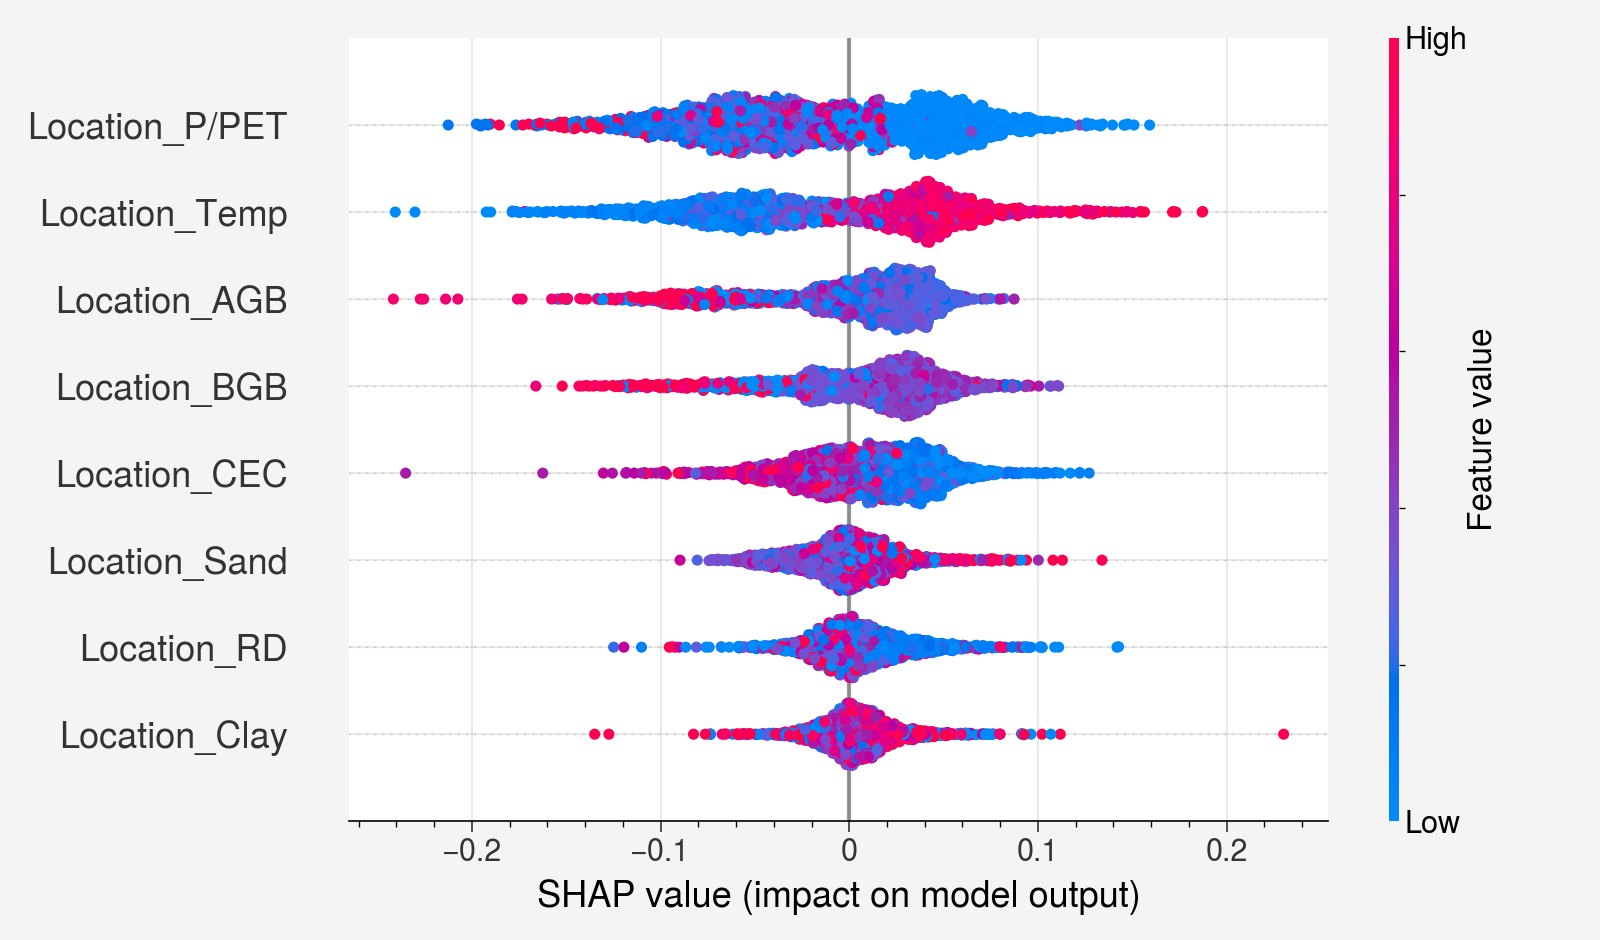

In [8]:

# Create an explainer object
explainer = shap.Explainer(model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot for global feature importance
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)


In [11]:
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns, max_display=30,show=False)
plt.tight_layout()
plt.savefig('I:/PF_NF_climate_sensitivity/all_datasets_reproduce/XGBT_model_analysis/lambda_XGBT/global_SHAP_location.pdf')
plt.close()

                      Location_P/PET  Location_Temp  Location_RD  \
Location_P/PET              1.000000      -0.582816    -0.342047   
Location_Temp              -0.582816       1.000000     0.441665   
Location_RD                -0.342047       0.441665     1.000000   
Location_AGB                0.198426      -0.086643     0.176302   
Location_BGB                0.271379      -0.235523     0.144365   
Location_CEC                0.573094      -0.804279    -0.454510   
Location_Clay              -0.357794       0.145170     0.125631   
Location_Sand               0.180403      -0.055407    -0.139391   
Delta_lambda_AC1_LAI       -0.322429       0.501673     0.158139   

                      Location_AGB  Location_BGB  Location_CEC  Location_Clay  \
Location_P/PET            0.198426      0.271379      0.573094      -0.357794   
Location_Temp            -0.086643     -0.235523     -0.804279       0.145170   
Location_RD               0.176302      0.144365     -0.454510       0.12563

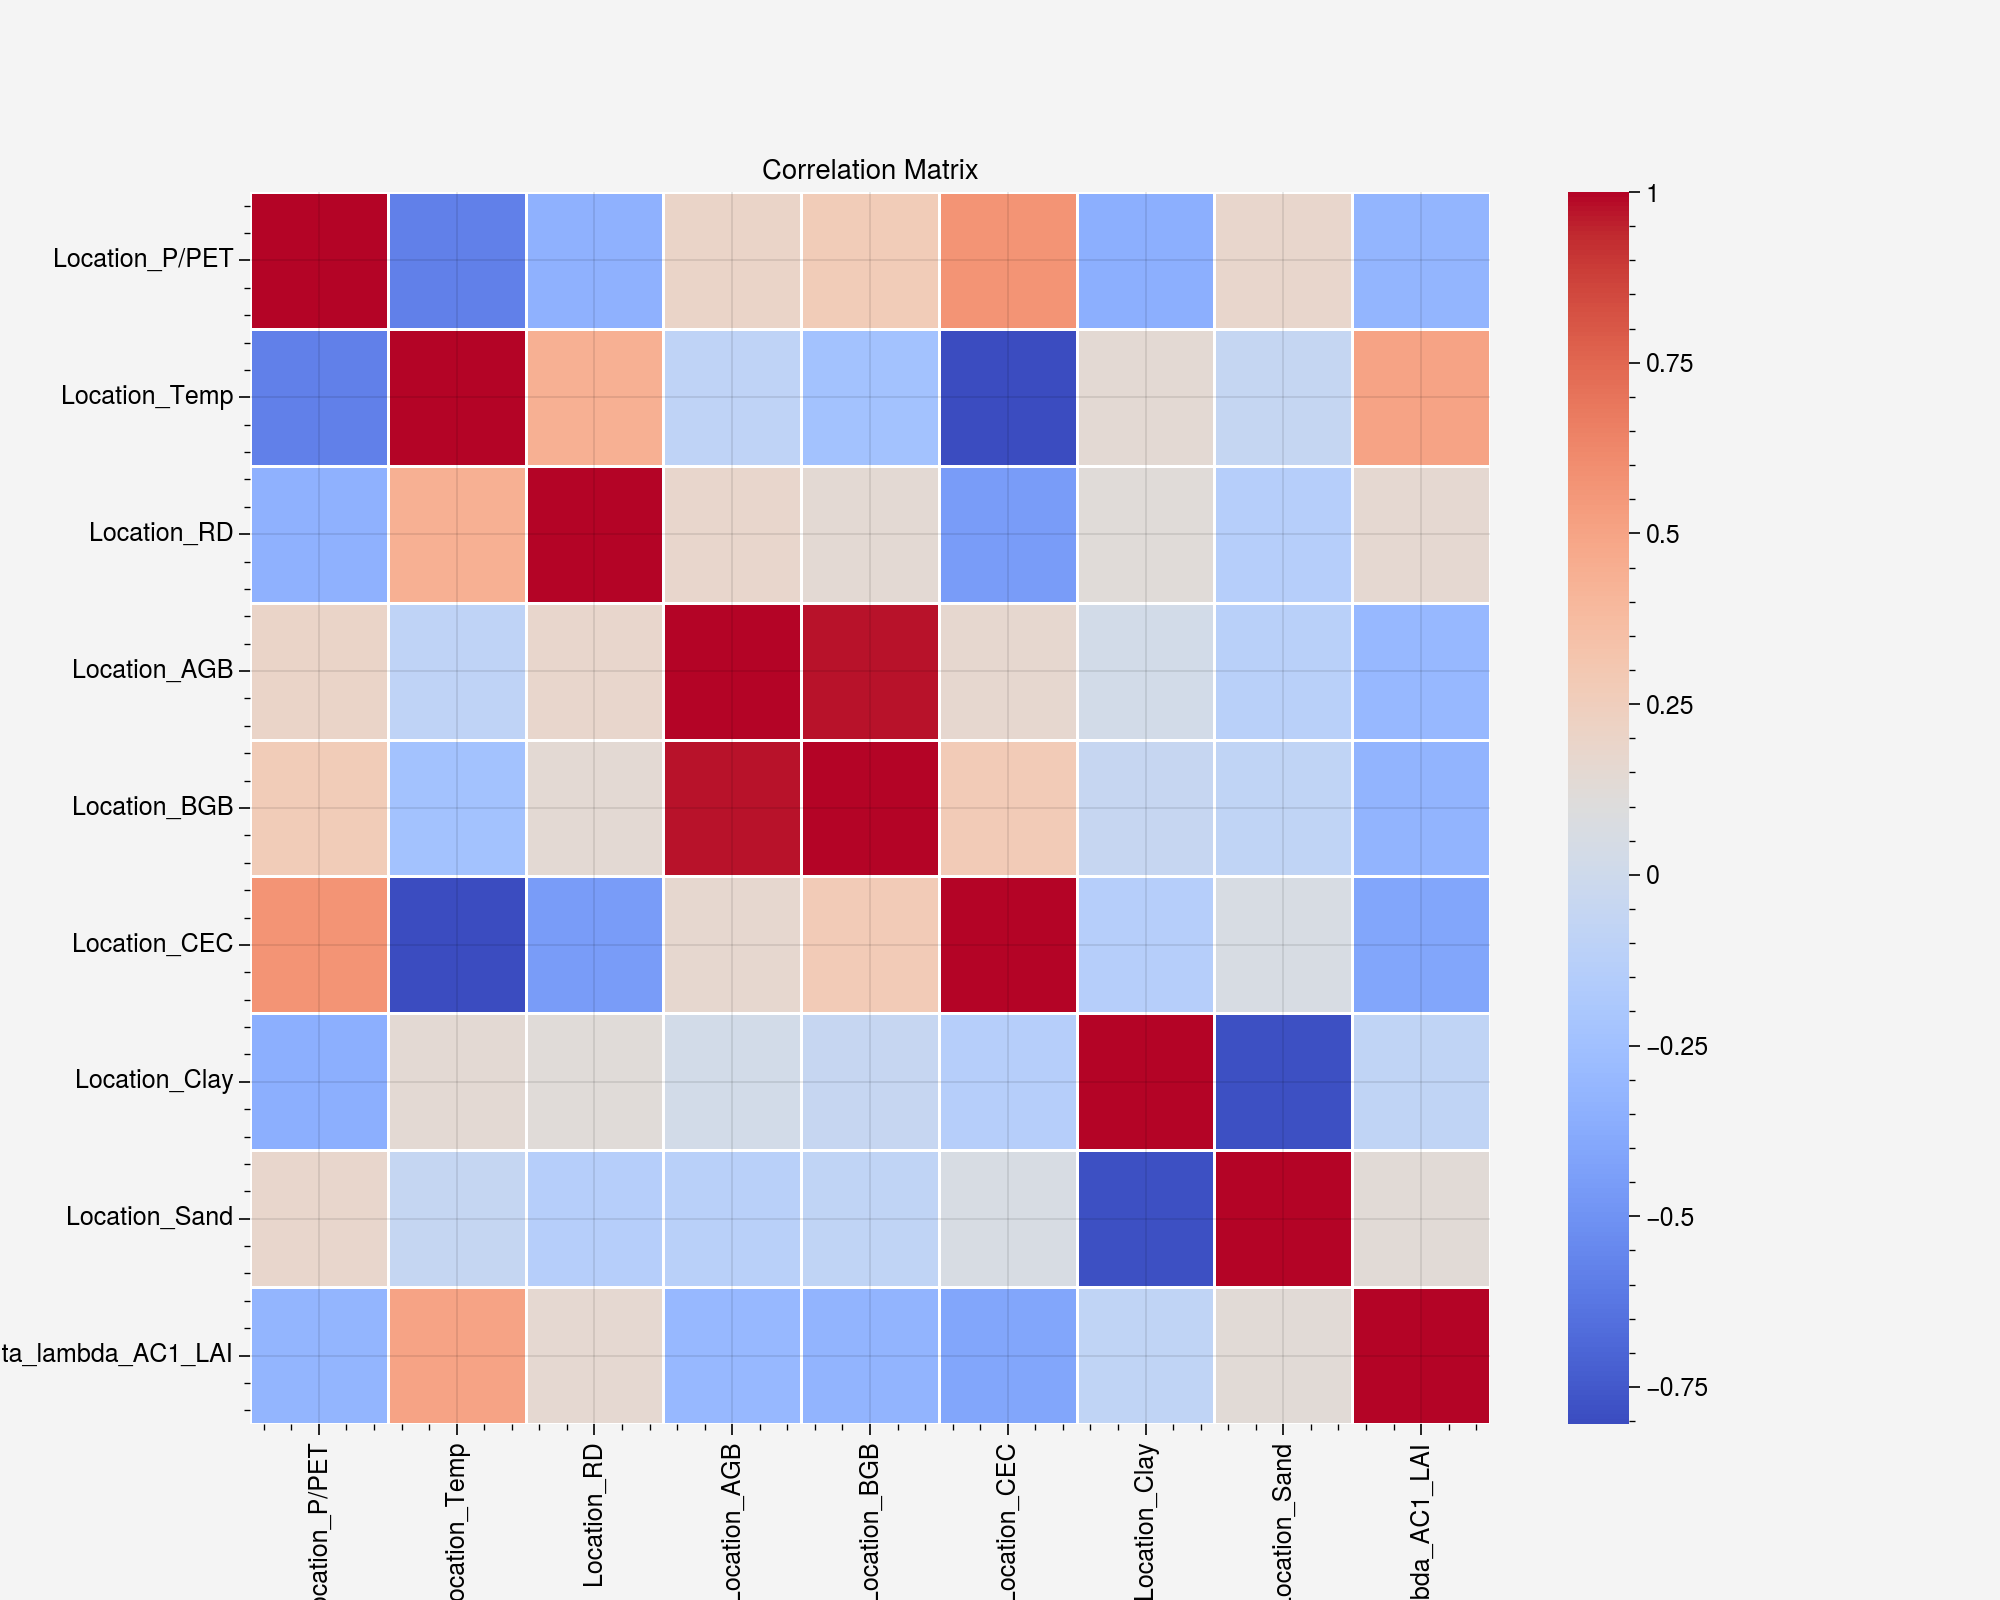

In [10]:
correlation_matrix = data.corr()
print(correlation_matrix)
plt.figure(figsize=(10, 8))  # 设置图形大小
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5,facecolor="white")
plt.title("Correlation Matrix")

# 保存图形到文件
#plt.savefig('F:/lambda_XGBT/Figures/Correlation.pdf')

plt.show()


